# Future Sales Prediction - Kaggle Competition

https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales/

#### File descriptions
- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.

- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.

- sample_submission.csv - a sample submission file in the correct format.

- items.csv - supplemental information about the items/products.

- item_categories.csv  - supplemental information about the items categories.

- shops.csv- supplemental information about the shops.

#### Data fields

- ID - an Id that represents a (Shop, Item) tuple within the test set

- shop_id - unique identifier of a shop

- item_id - unique identifier of a product

- item_category_id - unique identifier of item category

- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure

- item_price - current price of an item

- date - date in format dd/mm/yyyy

- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33

- item_name - name of item

- shop_name - name of shop

- item_category_name - name of item category

### I. Import the dataset and data analysis libraries

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [68]:
sales_train = pd.read_csv("data/sales_train.csv")
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [69]:
test = pd.read_csv("data/test.csv")
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [70]:
sample_submission = pd.read_csv("data/sample_submission.csv")
sample_submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [71]:
items = pd.read_csv("data/items.csv")
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [72]:
item_categories = pd.read_csv("data/item_categories.csv")
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [73]:
shops = pd.read_csv("data/shops.csv")
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


### II. Initial data checks and manipulations

In [74]:
sales_train.shape

(2935849, 6)

In [75]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


Note that the ```date``` column is not in the proper datetime format.

In [76]:
sales_train['date'] = pd.to_datetime(sales_train['date'], format = '%d.%m.%Y')
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [77]:
# Split into month, day, and year
sales_train['year'] = sales_train['date'].dt.year
sales_train['month'] = sales_train['date'].dt.month
sales_train['day'] = sales_train['date'].dt.day
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day
0,2013-01-02,0,59,22154,999.00,1.0,2013,1,2
1,2013-01-03,0,25,2552,899.00,1.0,2013,1,3
2,2013-01-05,0,25,2552,899.00,-1.0,2013,1,5
3,2013-01-06,0,25,2554,1709.05,1.0,2013,1,6
4,2013-01-15,0,25,2555,1099.00,1.0,2013,1,15


In [78]:
# Keep the month-year pair (in string format) to make date_block_num column more intelligible
sales_train['month_year'] = sales_train['date'].dt.strftime('%Y-%m-%d').str[:7]

# dt.strftime(...) to convert the datetime format of 'date' into string format
# str[:7] to extract the month and year in the date string

sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day,month_year
0,2013-01-02,0,59,22154,999.00,1.0,2013,1,2,2013-01
1,2013-01-03,0,25,2552,899.00,1.0,2013,1,3,2013-01
2,2013-01-05,0,25,2552,899.00,-1.0,2013,1,5,2013-01
3,2013-01-06,0,25,2554,1709.05,1.0,2013,1,6,2013-01
4,2013-01-15,0,25,2555,1099.00,1.0,2013,1,15,2013-01


In [79]:
sales_train.isna().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
year              0
month             0
day               0
month_year        0
dtype: int64

In [80]:
sales_train.nunique()

date               1034
date_block_num       34
shop_id              60
item_id           21807
item_price        19993
item_cnt_day        198
year                  3
month                12
day                  31
month_year           34
dtype: int64

In [81]:
# Describing datetime and quantitative variables
sales_train[['date', 'item_price', 'item_cnt_day']].describe()

,date,item_price,item_cnt_day
count,2935849,2.935849e+06,2.935849e+06
mean,2014-04-03 05:44:34.970681344,8.908532e+02,1.242641e+00
min,2013-01-01 00:00:00,-1.000000e+00,-2.200000e+01
25%,2013-08-01 00:00:00,2.490000e+02,1.000000e+00
50%,2014-03-04 00:00:00,3.990000e+02,1.000000e+00
75%,2014-12-05 00:00:00,9.990000e+02,1.000000e+00
max,2015-10-31 00:00:00,3.079800e+05,2.169000e+03
std,NaN,1.729800e+03,2.618834e+00


In [82]:
# Declaring categorical variables
sales_train['shop_id'] = pd.Categorical(sales_train['shop_id'])
sales_train['item_id'] = pd.Categorical(sales_train['item_id'])

In [83]:
# Describing categorical variables
sales_train[['month_year', 'shop_id', 'item_id']].describe()

,month_year,shop_id,item_id
count,2935849,2935849,2935849
unique,34,60,21807
top,2013-12,31,20949
freq,143246,235636,31340


In [84]:
print(f'Number of item_cnt_day values below 0: {sales_train[sales_train['item_cnt_day'] < 0].shape[0]}')

Number of item_cnt_day values below 0: 7356


In [85]:
# Convert negative to positive values in item_cnt_day
sales_train['item_cnt_day'] = sales_train['item_cnt_day'].abs()

In [86]:
# Create a "master table" for EDA in training data
sales_full = sales_train.merge(items, how = 'inner', on = 'item_id')\
                              .merge(item_categories, how = 'inner', on = 'item_category_id')\
                              .merge(shops, how = 'inner', on = 'shop_id')

sales_full.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day,month_year,item_name,item_category_id,item_category_name,shop_name
0,2013-01-02,0,59,22154,999.00,1.0,2013,1,2,2013-01,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,2013-01-03,0,25,2552,899.00,1.0,2013,1,3,2013-01,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
2,2013-01-05,0,25,2552,899.00,1.0,2013,1,5,2013-01,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
3,2013-01-06,0,25,2554,1709.05,1.0,2013,1,6,2013-01,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
4,2013-01-15,0,25,2555,1099.00,1.0,2013,1,15,2013-01,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум"""


### III. EDA for quantitative variables

Text(0.5, 1.03, 'Distribution of quantitative data')

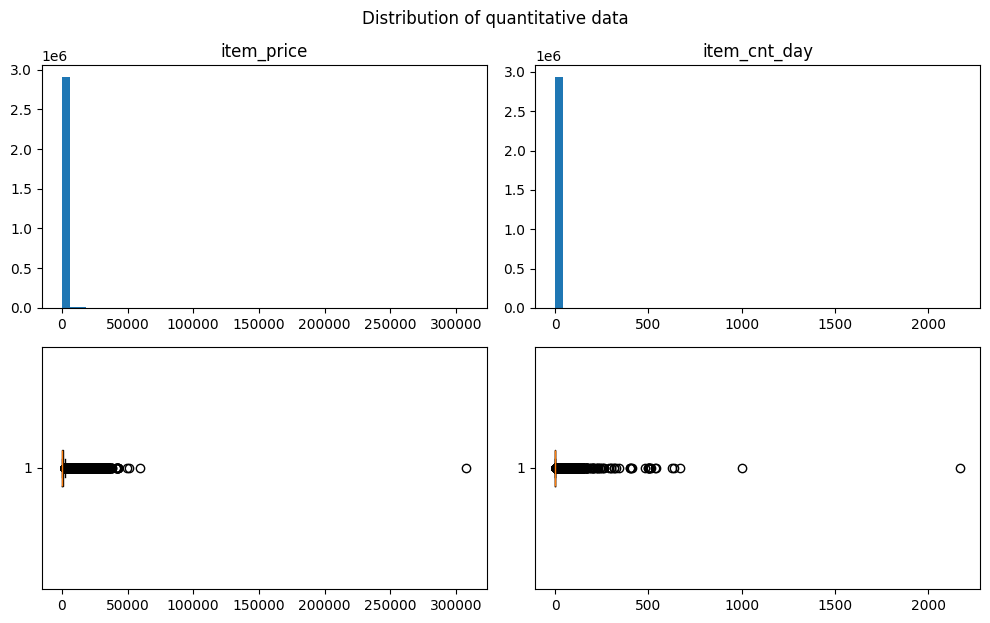

In [ ]:
# Distribution of quantitative data
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 6))
ax[0][0].hist(sales_full['item_price'], bins = 50)
ax[0][0].set_title('item_price')
ax[1][0].boxplot(sales_full['item_price'], vert = False)

ax[0][1].hist(sales_full['item_cnt_day'], bins = 50)
ax[0][1].set_title('item_cnt_day')
ax[1][1].boxplot(sales_full['item_cnt_day'], vert = False)

plt.tight_layout()
fig.suptitle('Distribution of quantitative data', y = 1.03)

Text(0.5, 1.03, 'Distribution of quantitative data (massive outliers removed)')

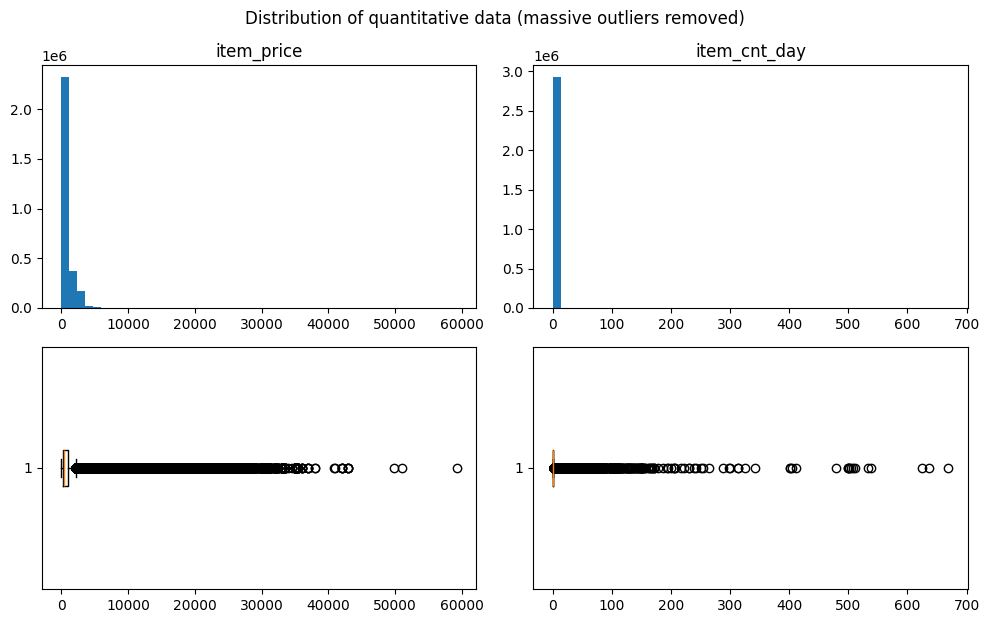

In [88]:
# Removing massive outliers
price_no_outliers = sales_full[sales_full['item_price'] < 300000]
cnt_no_outliers = sales_full[sales_full['item_cnt_day'] < 1000]


fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 6))
ax[0][0].hist(price_no_outliers['item_price'], bins = 50)
ax[0][0].set_title('item_price')
ax[1][0].boxplot(price_no_outliers['item_price'], vert = False)

ax[0][1].hist(cnt_no_outliers['item_cnt_day'], bins = 50)
ax[0][1].set_title('item_cnt_day')
ax[1][1].boxplot(cnt_no_outliers['item_cnt_day'], vert = False)

plt.tight_layout()
fig.suptitle('Distribution of quantitative data (massive outliers removed)', y = 1.03)

### IV. EDA for categorical variables

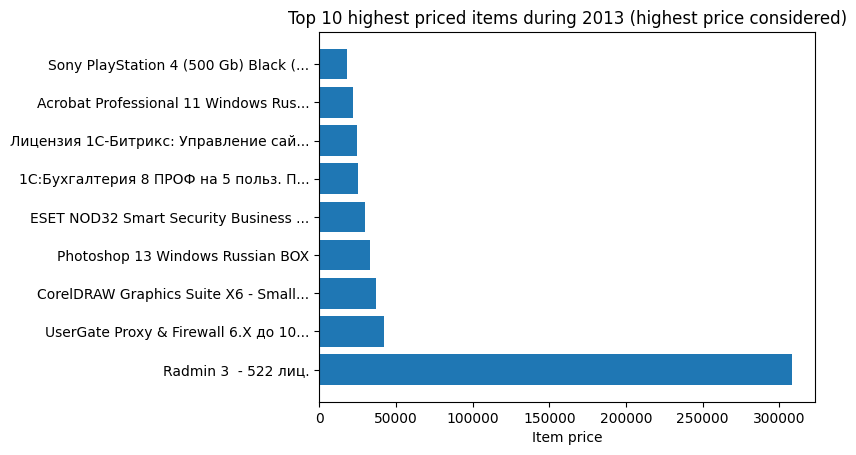

In [145]:
# Top 10 highest priced item (with names) during 2013
highest_priced_2013 = sales_full[sales_full['year'] == 2013][['item_id', 'item_name', 'item_price']] # keep only necessary columns
highest_priced_2013.drop_duplicates(subset = ['item_id'], inplace = True) # drop duplicates
highest_priced_2013 = highest_priced_2013.sort_values('item_price', ascending = False).iloc[:10] # sort for top 10

# Truncate item names to 35 characters because many of them are so long
highest_priced_2013['item_name_trunc'] = highest_priced_2013['item_name'].case_when([
    (highest_priced_2013['item_name'].str.len() <= 35, highest_priced_2013['item_name']),
    (highest_priced_2013['item_name'].str.len() > 35, highest_priced_2013['item_name'].str[:35] + "...")
])

fig, ax = plt.subplots()
ax.barh(highest_priced_2013['item_name_trunc'], highest_priced_2013['item_price'])

ax.set_xlabel('Item price')
ax.set_title('Top 10 highest priced items during 2013 (highest price considered)')
plt.show()

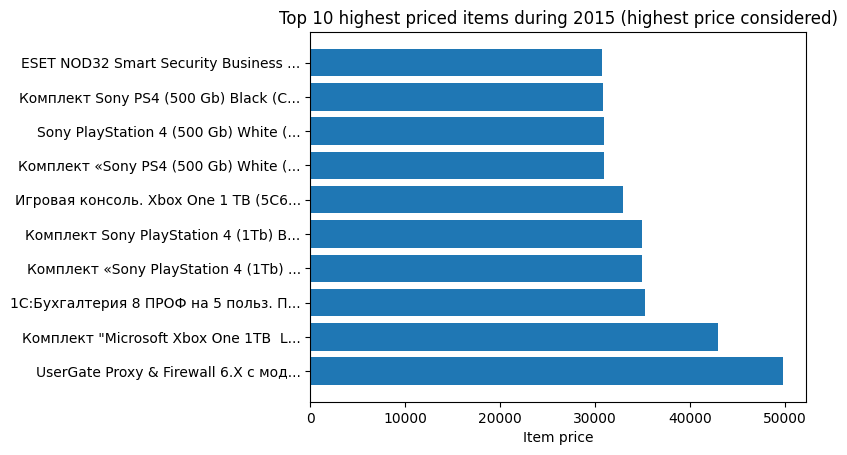

In [146]:
# Top 10 highest priced item (with names) during 2015
highest_priced_2015 = sales_full[sales_full['year'] == 2015][['item_id', 'item_name', 'item_price']]
highest_priced_2015.drop_duplicates(subset = ['item_id'], inplace = True)
highest_priced_2015 = highest_priced_2015.sort_values('item_price', ascending = False).iloc[:10]

highest_priced_2015['item_name_trunc'] = highest_priced_2015['item_name'].case_when([
    (highest_priced_2015['item_name'].str.len() <= 35, highest_priced_2015['item_name']),
    (highest_priced_2015['item_name'].str.len() > 35, highest_priced_2015['item_name'].str[:35] + "...")
])

fig, ax = plt.subplots()
ax.barh(highest_priced_2015['item_name_trunc'], highest_priced_2015['item_price'])

ax.set_xlabel('Item price')
ax.set_title('Top 10 highest priced items during 2015 (highest price considered)')
plt.show()

### V. Adding the time series element

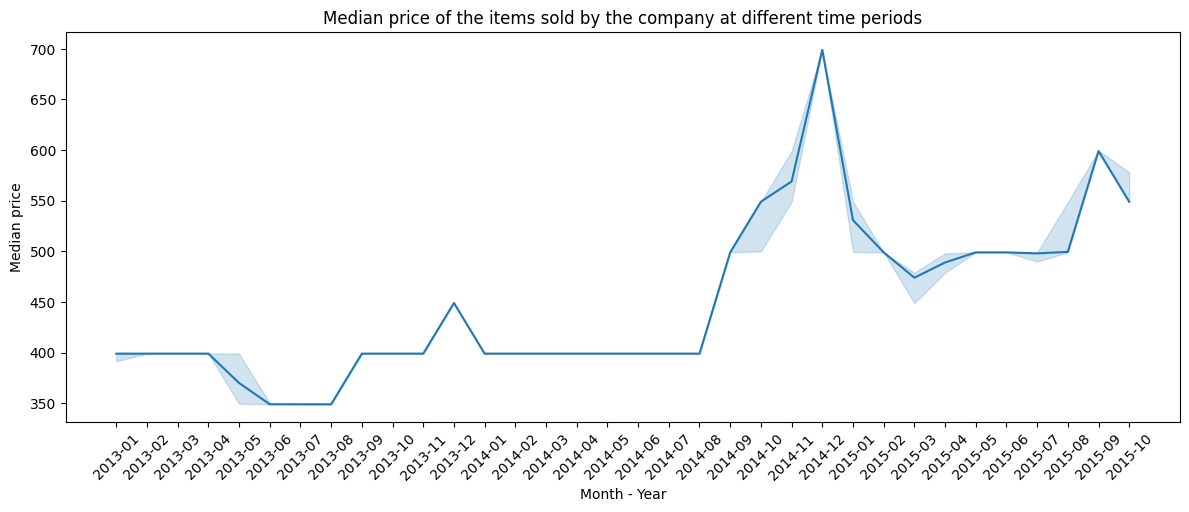

In [112]:
# Median price over time
fig, ax = plt.subplots(figsize = (12, 5))

sns.lineplot(data = sales_full, x = 'month_year', y = 'item_price', estimator = 'median', ax = ax)
ax.tick_params(axis = 'x', labelrotation = 45)
plt.tight_layout()

ax.set_xlabel('Month - Year')
ax.set_ylabel('Median price')
ax.set_title('Median price of the items sold by the company at different time periods')
plt.show()

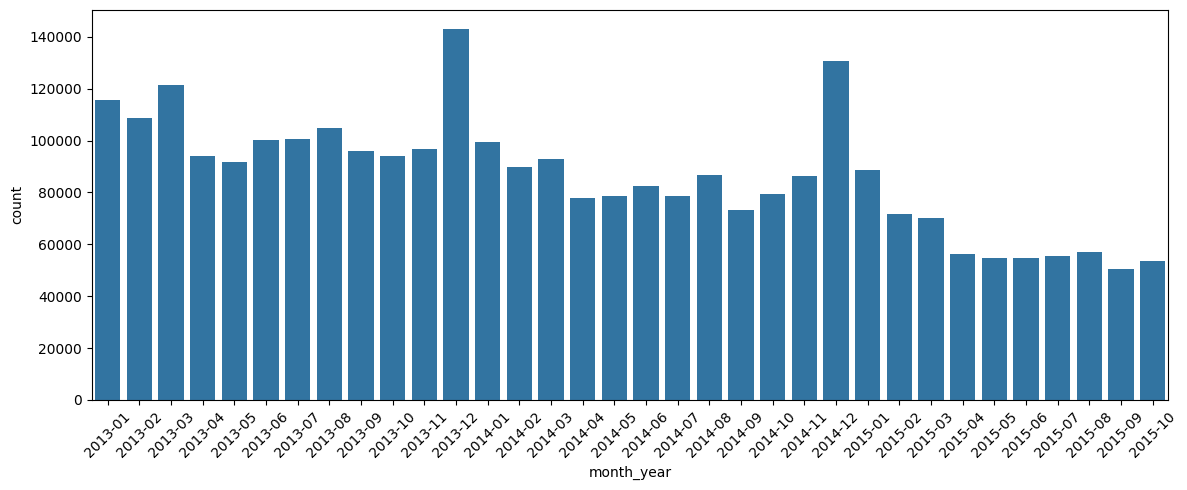

In [ ]:
# Number of (store_id, item_id) pairs throughout each month-year pair
# Note that I should remember to count duplicates
# https://www.geeksforgeeks.org/python/how-to-count-duplicates-in-pandas-dataframe/

fig, ax = plt.subplots(figsize = (12, 5))
sns.countplot(data = sales_full, x = 'month_year', ax = ax)
ax.tick_params(axis = 'x', labelrotation = 45)
plt.tight_layout()

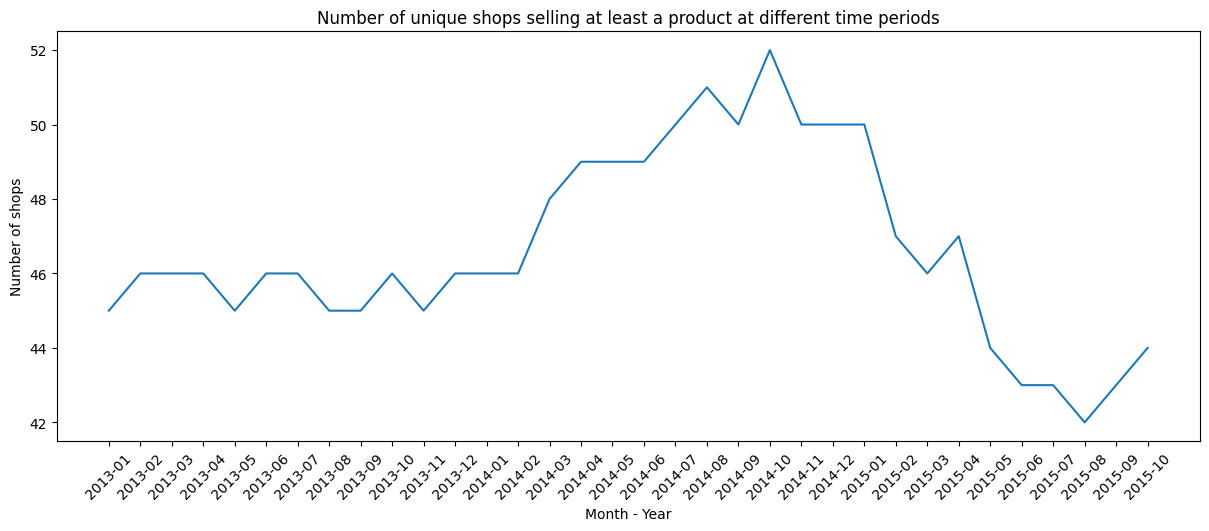

In [ ]:
# Count number of distinct shops by month-year pair
shop_count_my = sales_full[['month_year', 'shop_id']].groupby('month_year').nunique()
# .nunique() to denote that we only care about the number of distinct shops
shop_count_my = shop_count_my.reset_index()
# Move the month-year outside the index for more convenient plotting

fig, ax = plt.subplots(figsize = (12, 5))
ax.plot(shop_count_my['month_year'], shop_count_my['shop_id'])
ax.tick_params(axis = 'x', labelrotation = 45)
plt.tight_layout()

ax.set_xlabel('Month - Year')
ax.set_ylabel('Number of shops')
ax.set_title('Number of unique shops selling at least a product at different time periods')
plt.show()

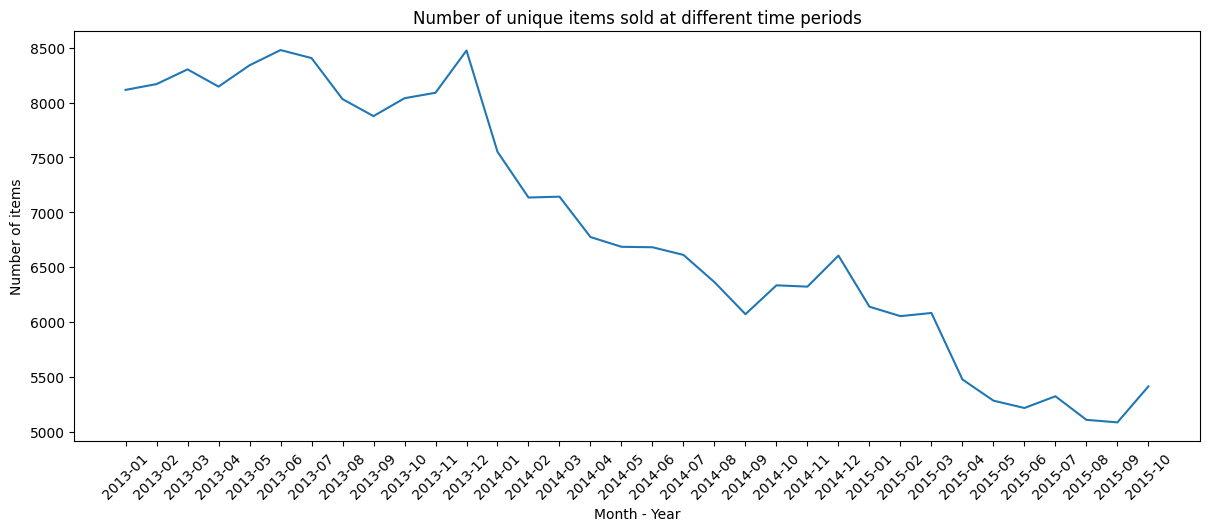

In [ ]:
# Count number of distinct shops by month-year pair
shop_count_my = sales_full[['month_year', 'item_id']].groupby('month_year').nunique()
# .nunique() to denote that we only care about the number of distinct shops
shop_count_my = shop_count_my.reset_index()
# Move the month-year outside the index for more convenient plotting

fig, ax = plt.subplots(figsize = (12, 5))
ax.plot(shop_count_my['month_year'], shop_count_my['item_id'])
ax.tick_params(axis = 'x', labelrotation = 45)
plt.tight_layout()

ax.set_xlabel('Month - Year')
ax.set_ylabel('Number of items')
ax.set_title('Number of unique items sold at different time periods')
plt.show()